# Aim and objectives
The aim of the analyses is to examine the temperature profiles of different landcover types across elevation gradients. In this example, we will collect [Land Surface Temperature (LST)](https://docs.planet.com/data/planetary-variables/land-surface-temperature/techspec/) for two landcover types `forest` and `low_vegetation` across six elevation gradiants in OSA peninsula. 

The chosen elevation categories are: 

| Code | Elevation Range       |
|----|-------------|
| 1  | => 0 < 300     |
| 2  | => 300 < 600   |
| 3  | => 600 < 900   |
| 4  | => 900 < 1200  |
| 5  | => 1200 < 1500 |
| 6  | => 1500 < 1800 |

The codes for the two landcover types are: 
| Code | Landcover Type       |
|----|-------------|
| 10  | forest  |
| 30  | low vegetation  |

To combine these two categories, landcover types accross elevation gradients are represented as ``` lancover type code``` x 10 + ``` elevation code```: 
| Code | Landcover Type accross Elevation Gradients     |
|----|-------------|
| 101  | forest at => 0 < 300  |
| 102  | forest at => 300 < 600  |
|... | ... |
| 301  | low vegetation at => 0 < 300  |
| 302  | low vegetation at => 300 < 600  |
|... | ... |

For each of the reuslting categories we have prepared 100 random points, resulting in 1200 refrence points in total as illustrated below. We are extracting LST data for 01/03/2023 as this was one of the days with the greatest LST values for 2023 (identified in previous test runs).

![alt text](../media/sf_points.png) 



# Required libraries

In [7]:
from getpass import getpass
from shapely.geometry import mapping

import geopandas as gpd
import pandas as pd

from helpers import stats_to_df, authenticate_sentinel_hub, build_json_request

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Authentication
To use **Sentinel Hub API**, you need to authenticate with using **OAuth2** credentials. These are available from your [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard/),

Get your `CLIENT_ID` and `CLIENT_SECRET` from the **Dashboard** -> **My Account** _> **OAuth Clients**.
Get your `DATA_SET` ID from [Insight Platform](https://insights.planet.com/analyze/configurations/) -> **Your Collection** -> **Collection ID**

In [3]:
CLIENT_ID = getpass("Enter your Sentinel Hub CLIENT_ID: ")
CLIENT_SECRET = getpass("Enter your Sentinel Hub CLIENT_SECRET: ")
DATA_SET = getpass("Enter you data ID")

oauth = authenticate_sentinel_hub(CLIENT_ID, CLIENT_SECRET)

# Get Your Data Ready

Provide a **GeoJSON** file containing the geographic area or features you want to work with, the start and end date (YYYYY-MM-DD) for the timeframe of your analyses, and the desired day interval. Keep in mind that the geometries need to be polygons, as the Sentinel Hub API does not accept points. If you still want to work with points, the only solution is to provide extremely small buffer polygons representing the points (as was done in our case).

In [ ]:
data = "../data/squaressf.geojson" 
start_date = "2023-03-01"
end_date = "2023-03-02"
day_interval = '1' #the interval of days for which data will be retrieved. For daily analyses set day_interval = 1
results = []

In [9]:
geodataframe = gpd.read_file(data)
geodataframe = geodataframe.to_crs("EPSG:4326")
geodataframe.rename(columns={'Band_1': 'land_type'}, inplace=True)
geodataframe

,land_type,geometry
0,101.0,"POLYGON ((-83.62266 8.64151, -83.62266 8.6415,..."
1,101.0,"POLYGON ((-83.53891 8.47052, -83.53891 8.47051..."
2,101.0,"POLYGON ((-83.56737 8.60158, -83.56737 8.60157..."
3,101.0,"POLYGON ((-83.52176 8.45721, -83.52176 8.4572,..."
4,101.0,"POLYGON ((-83.29247 8.69041, -83.29247 8.69041..."
...,...,...
1195,306.0,"POLYGON ((-83.31414 9.33983, -83.31414 9.33982..."
1196,306.0,"POLYGON ((-83.2607 9.30175, -83.2607 9.30174, ..."
1197,306.0,"POLYGON ((-83.16148 9.22748, -83.16148 9.22747..."
1198,306.0,"POLYGON ((-83.23584 9.3055, -83.23584 9.30549,..."


# 

# Send request to the Sentinel Hub API

We will use the Statistical API of Sentinel Hub, as it allows us to obtain statistical information for a large collection of small geometries. Note, that this works only for polygons, as currunt inplementation of the API does not allow us to do those analyses with point data.

For each polygon, we send a JSON request to the Statistical API. We store the JSON response, containing the results, in a list, that we will convert later in a pandas dataframe for easier handling.

⚠️ The JSON dataset in this example consists of 1200 polygons and it takes arround 20 minutes to get a response from the server. If you want to just quickly test the code, then refer to ``` 01_simple_demo.ipynb ``` or use the  ``` data/test_bbox_landcover.geojson ``` instead.

In [10]:
for geoshape in geodataframe.geometry.values:
  geometry = mapping(geoshape)

  # Build JSON
  json_request = build_json_request(geometry, start_date, end_date, day_interval, DATA_SET)

  # Set the request url and headers
  url = "https://services.sentinel-hub.com/api/v1/statistics"
  headers = {
  "Accept": "application/json",
  "Content-Type": "application/json"
  }

  #Send the request
  response = oauth.request(
    "POST", url, headers=headers, json = json_request
  )

  results.append(response.json())


Let's now convert this data into a tabular form by transforming it into a `pandas` dataframe.

In [35]:
dataframe = [stats_to_df(result) for result in results]

for df, land_type in zip(dataframe, geodataframe['land_type'].values):
    df["land_type"] = land_type

dataframe = pd.concat(dataframe)

dataframe

,interval_from,interval_to,eobrowserStats_B0_min,eobrowserStats_B0_max,eobrowserStats_B0_mean,eobrowserStats_B0_stDev,eobrowserStats_B0_sampleCount,eobrowserStats_B0_noDataCount,land_type
0,2023-03-01,2023-03-02,306.500000,306.500000,306.500000,0.0,65536,0,101.0
0,2023-03-01,2023-03-02,306.000000,306.000000,306.000000,0.0,65536,0,101.0
0,2023-03-01,2023-03-02,306.450012,306.450012,306.450012,0.0,65536,0,101.0
0,2023-03-01,2023-03-02,304.119995,304.119995,304.119995,0.0,65536,0,101.0
0,2023-03-01,2023-03-02,305.799988,305.799988,305.799988,0.0,65536,0,101.0
...,...,...,...,...,...,...,...,...,...
0,2023-03-01,2023-03-02,304.579987,304.579987,304.579987,0.0,65536,0,306.0
0,2023-03-01,2023-03-02,308.809998,308.809998,308.809998,0.0,65536,0,306.0
0,2023-03-01,2023-03-02,303.940002,303.940002,303.940002,0.0,65536,0,306.0
0,2023-03-01,2023-03-02,307.130005,307.130005,307.130005,0.0,65536,0,306.0


This process might require some time (20 minutes in our example), so let's save the data as csv file, in case we will need it later and we don't want to wait the response of the server every time.

In [ ]:
dataframe.to_csv('../data/LST_2023_03_01_original.csv', index=False)

We will also clean up a bit the data and add ``` land_class ``` and ``` elevation_class``` columns based on the land type categorization we did earlier (see Aims and Objectives section)

In [36]:
# Create new columns
dataframe['land_class'] = dataframe['land_type'] // 10    # first two digits (e.g., 30)
dataframe['elev_class'] = dataframe['land_type'] % 10     # last digit (e.g., 1, 2, 3)
dataframe.rename(columns={'eobrowserStats_B0_mean': 'LST'}, inplace=True)
dataframe.drop(['eobrowserStats_B0_min','eobrowserStats_B0_max','eobrowserStats_B0_stDev','eobrowserStats_B0_sampleCount','eobrowserStats_B0_noDataCount'], axis=1, inplace=True)
dataframe

,interval_from,interval_to,LST,land_type,land_class,elev_class
0,2023-03-01,2023-03-02,306.500000,101.0,10.0,1.0
0,2023-03-01,2023-03-02,306.000000,101.0,10.0,1.0
0,2023-03-01,2023-03-02,306.450012,101.0,10.0,1.0
0,2023-03-01,2023-03-02,304.119995,101.0,10.0,1.0
0,2023-03-01,2023-03-02,305.799988,101.0,10.0,1.0
...,...,...,...,...,...,...
0,2023-03-01,2023-03-02,304.579987,306.0,30.0,6.0
0,2023-03-01,2023-03-02,308.809998,306.0,30.0,6.0
0,2023-03-01,2023-03-02,303.940002,306.0,30.0,6.0
0,2023-03-01,2023-03-02,307.130005,306.0,30.0,6.0


Let's save the cleaned version of the table in a separate csv file

In [ ]:
dataframe.to_csv('../data/LST_2023_03_01_cleaned.csv', index=False)

# Visualization 

Now we will plot the time series of LST mean values for each landcover type.

In [49]:
# Add a new column for renamed classes
dataframe["land_class_label"] = dataframe["land_class"].map({10: "forest", 30: "low vegetation"})

In [53]:
dataframe

,interval_from,interval_to,LST,land_type,land_class,elev_class,land_class_label
0,2023-03-01,2023-03-02,306.500000,101.0,10.0,1.0,forest
0,2023-03-01,2023-03-02,306.000000,101.0,10.0,1.0,forest
0,2023-03-01,2023-03-02,306.450012,101.0,10.0,1.0,forest
0,2023-03-01,2023-03-02,304.119995,101.0,10.0,1.0,forest
0,2023-03-01,2023-03-02,305.799988,101.0,10.0,1.0,forest
...,...,...,...,...,...,...,...
0,2023-03-01,2023-03-02,304.579987,306.0,30.0,6.0,low vegetation
0,2023-03-01,2023-03-02,308.809998,306.0,30.0,6.0,low vegetation
0,2023-03-01,2023-03-02,303.940002,306.0,30.0,6.0,low vegetation
0,2023-03-01,2023-03-02,307.130005,306.0,30.0,6.0,low vegetation


Text(0, 0.5, 'Land Surface Temperature (K)')

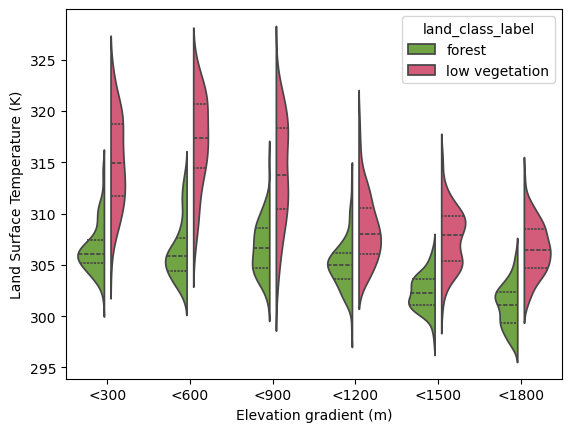

In [55]:
sns.violinplot(
    data=dataframe, 
    x="elev_class", 
    y="LST", 
    hue="land_class_label",
    palette={'forest': "#70B434", 'low vegetation': "#e74870"},
    gap=.2, 
    split=True, 
    inner="quart"
)
# Custom X-axis tick labels
custom_labels = [
    "<300", 
    "<600", 
    "<900", 
    "<1200", 
    "<1500", 
    "<1800"
]

# Apply new tick labels
plt.xticks(ticks=range(6), labels=custom_labels)

# Edit axis labels
plt.xlabel("Elevation gradient (m)")
plt.ylabel("Land Surface Temperature (K)")
